# Code to Run Spatial Attention on Custom CNN model


### Mounting Google drive to read dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Paths to be defined here

In [ ]:
'''
Declare all paths which are used to trian and save
'''
# Path to saved dataset which is already created for real world
dataset_path = '/content/drive/MyDrive/Master_Project/Dataset/real_world_data.npz'
# Path for best model which is saved
best_cnn_model_path = "/content/drive/MyDrive/Master_Project/Models/"

### All Major imports

In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools
import datetime

import cv2
import os
import io

### Loading saved data set from numpy saved file

In [ ]:
#Load to start the work.
#Load the datasets
import numpy as np

data = np.load(dataset_path)

# Extracting the datasets
x_train = data['x_train']
y_train = data['y_train']
x_test = data['x_test']
y_test = data['y_test']
x_val = data['x_val']
y_val = data['y_val']

### Spatial Attention with CNN model

In [ ]:
'''
Function to create spatial attention on the images during training
'''
def spatial_attention_module(x, return_attention=False):
    # Average Pooling
    x1 = tf.reduce_mean(x, axis=-1, keepdims=True)
    # Max Pooling
    x2 = tf.reduce_max(x, axis=-1, keepdims=True)
    # Concatenate both the features for feature map
    feats = tf.concat([x1, x2], axis=-1)
    # Conv layer
    attention_weights = Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats)
    modified_feats = tf.multiply(x, attention_weights)

    if return_attention:
        return modified_feats, attention_weights
    else:
        return modified_feats


In [ ]:
'''
Fucntion which can be used to visualatize how data is depicted using visualisation
'''
import matplotlib.pyplot as plt

def visualize_attention(input_image):
    # Assuming input_image is preprocessed and ready to be fed into the model
    # Make sure to expand dimensions if your model expects a batch
    input_image_batch = tf.expand_dims(input_image, axis=0)

    # Get the modified output and attention weights
    _, attention_weights = spatial_attention_module(input_image_batch, return_attention=True)

    # Squeeze to remove batch dimension and any singleton dimensions
    attention_weights = tf.squeeze(attention_weights)

    return attention_weights

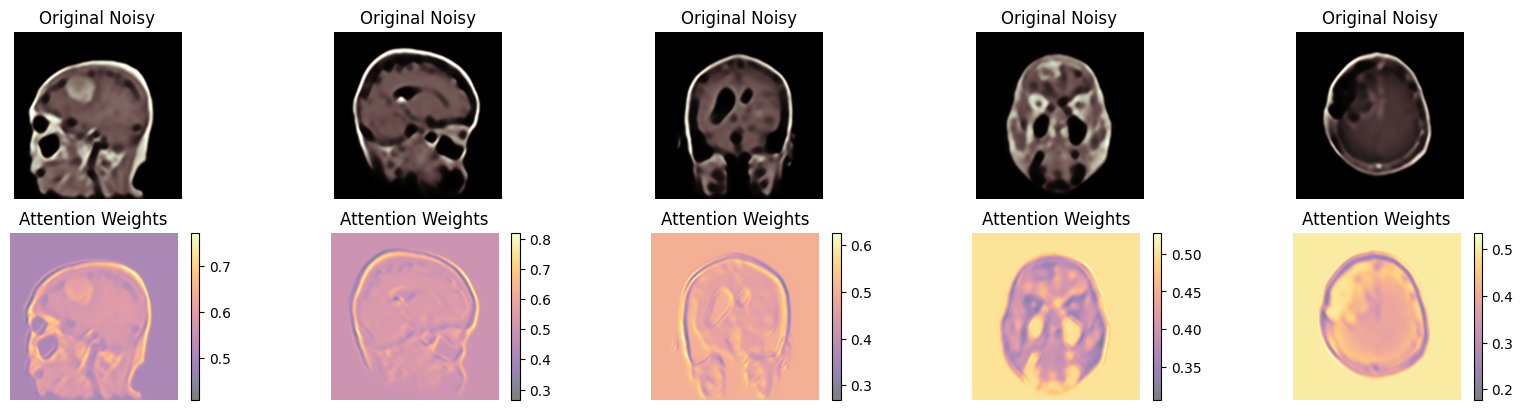

In [ ]:
'''
We pass the number of images you want to visualisation
Which then randomly picks images from the train datset and
performes spatial attention on them and displays
'''
num_images = 5
indices = np.random.choice(x_train_preprocessed_denoised_deblurred.shape[0], num_images, replace=False)
plt.figure(figsize=(20, 10))
for i, index in enumerate(indices):
  input_image = x_train_preprocessed_denoised_deblurred[index]
  # Original Noisy Images
  plt.subplot(4, num_images, i + 1)
  plt.imshow(input_image)
  plt.title("Original Noisy")
  plt.axis('off')

    # Denoised Images
  plt.subplot(4, num_images, num_images + i + 1)
  plt.imshow(visualize_attention(input_image), cmap='inferno', alpha=0.5)
  plt.colorbar()  # Adds a colorbar to match colors with values
  plt.title("Attention Weights")
  plt.axis('off')

In [ ]:
'''
Creation of CNN model using the above sptial defination decalred
function takes shape and num of classes to be classifed as input
'''
def create_cnn_with_spatial_attention(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # CNN
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Spatial Attention
    x = spatial_attention_module(x)


    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)


    model = Model(inputs=inputs, outputs=x)
    return model

In [ ]:
'''
Paramter which are used for creation of the above defined model
'''
input_shape = (200, 200, 3)
num_classes = 4
model = create_cnn_with_spatial_attention(input_shape, num_classes)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 200, 200, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 200, 200, 32)         128       ['conv2d_5[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 100, 100, 32)         0         ['batch_normalization[0][0

In [ ]:
'''
Compiling the model using loss function and metrics to evaluate
'''
from keras.optimizers import Adam
model.compile(optimizer= Adam(learning_rate=0.001),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0)
model_checkpoint = ModelCheckpoint(best_cnn_model_path + 'best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)


In [ ]:
'''
Trying to fit the model
Batch size as 20
Epochs as 50
Using validation
We are keeping early stop
'''
history = model.fit(x_train_preprocessed_denoised_deblurred, y_train,
                    batch_size=20,
                    epochs=50,
                    validation_data=(x_val_preprocessed_denoised_deblurred, y_val),
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])

Epoch 1/50
229/229 [==============================] - ETA: 0s - loss: 0.9842 - accuracy: 0.7131
Epoch 1: val_loss improved from inf to 3.91659, saving model to /content/drive/MyDrive/Master_Project/Models/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 32s 116ms/step - loss: 0.9842 - accuracy: 0.7131 - val_loss: 3.9166 - val_accuracy: 0.3998 - lr: 0.0010
Epoch 2/50
228/229 [============================>.] - ETA: 0s - loss: 0.5136 - accuracy: 0.8020
Epoch 2: val_loss improved from 3.91659 to 0.43141, saving model to /content/drive/MyDrive/Master_Project/Models/best_model.h5
229/229 [==============================] - 5s 20ms/step - loss: 0.5132 - accuracy: 0.8021 - val_loss: 0.4314 - val_accuracy: 0.8285 - lr: 0.0010
Epoch 3/50
229/229 [==============================] - ETA: 0s - loss: 0.3924 - accuracy: 0.8453
Epoch 3: val_loss improved from 0.43141 to 0.40581, saving model to /content/drive/MyDrive/Master_Project/Models/best_model.h5
229/229 [==============================] - 5s 20ms/step - loss: 0.3924 - accuracy: 0.8453 - val_loss: 0.4058 - val_accuracy: 0.8364 - lr: 0.0010
Epoch 4/50
229/229 [==============================] - ETA: 0s - loss: 0.3211 - accuracy: 0.8838
Epoch 4: val_loss imp

In [ ]:
'''
Testing our model
'''
test_loss, test_acc = model.evaluate(x_test_preprocessed_denoised_deblurred, y_test)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

41/41 [==============================] - 1s 14ms/step - loss: 0.2720 - accuracy: 0.9314
Test accuracy: 0.9313501119613647
Test loss: 0.27199092507362366
